In [103]:
import os
import pandas as pd

# Define the folder path
folder_path = "Merge Attribution Scores 14B"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Load and concatenate all CSVs
merged_df = pd.concat(
    [pd.read_csv(os.path.join(folder_path, f)) for f in csv_files],
    ignore_index=True
)

# Sort merged_df by the numeric part of QA_ID
merged_df["QA_ID_num"] = merged_df["QA_ID"].str.extract(r"Q(\d+)").astype(int)
merged_df = merged_df.sort_values("QA_ID_num").drop(columns="QA_ID_num").reset_index(drop=True)

# Optionally save to a new CSV file
merged_df.to_csv("merged_attribution_scores_14B.csv", index=False)
print(merged_df)

            Score                                             Source  \
0        0.000000                                                  .   
1        0.000000  Due to his significant immunocompromise, the c...   
2        0.000000  The patient also had a new-onset cough but was...   
3      145.327247  A man in his 30s with AIDS presented with acut...   
4       12.684933  For rapid bedside differentiation of multiple ...   
...           ...                                                ...   
32121   -0.506488                   Cardiac examination shows an S4.   
32122    1.315400  A 52-year-old man is brought to the emergency ...   
32123    0.735411  His pulse is 80/min, and blood pressure is 130...   
32124    0.225078  While undergoing an ECG, the patient says that...   
32125    0.368033               The lungs are clear to auscultation.   

             QA_ID Extracted_Answer  \
0         Merge Q1                D   
1         Merge Q1                D   
2         Merge Q1

In [105]:

# Merge 'answer' and 'data_source' into merged_df based on 'QA_ID'
merged_df = merged_df.merge(
    df[["QA_ID", "answer", "data_source"]],
    on="QA_ID",
    how="left"  # Use 'left' to retain all rows from merged_df
)

merged_df.to_csv("merged_attribution_scores_14B_answers.csv", index=False)


In [106]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Load both DataFrames
df = pd.read_csv("merged_llm_4k_questions_with_QA_ID.csv")  # the source of correct sentence order
merged_df = pd.read_csv("merged_attribution_scores_14B.csv")  # messy sentence ordering

# Step 1: Build a mapping from QA_ID to sentence list (correct order)
context_sentences_dict = {}
for _, row in df.iterrows():
    qa_id = row["QA_ID"]
    context = str(row["context"])
    context_sentences = sent_tokenize(context)
    context_sentences_dict[qa_id] = context_sentences

# Step 2: Assign order index to each row in merged_df based on sentence position in context
def get_sentence_index(row):
    qa_id = row["QA_ID"]
    sentence = str(row["Source"]).strip()
    context_sents = context_sentences_dict.get(qa_id, [])
    try:
        return context_sents.index(sentence)
    except ValueError:
        return float('inf')  # Put unmatched sentences at the end

merged_df["order_index"] = merged_df.apply(get_sentence_index, axis=1)

# Step 3: Sort merged_df by QA_ID and the new order index
merged_df = merged_df.sort_values(by=["QA_ID", "order_index"]).drop(columns="order_index").reset_index(drop=True)


[nltk_data] Downloading package punkt to /data/healthy-
[nltk_data]     ml/scratch/yuexing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [107]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

# If you haven’t already downloaded the Punkt models:
nltk.download('punkt')

# 1. Load both DataFrames
df        = pd.read_csv("merged_llm_4k_questions_with_QA_ID.csv")  # holds the correct context & answers
merged_df = pd.read_csv("merged_attribution_scores_14B.csv")       # to be reordered

# 2. Build a lookup from QA_ID → list of sentences (correct order)
context_sentences_dict = {}
for _, row in df.iterrows():
    qa_id   = row["QA_ID"]
    context = str(row["context"])
    context_sentences_dict[qa_id] = sent_tokenize(context)

# 3. Compute a temporary order index in merged_df
def get_sentence_index(row):
    qa_id   = row["QA_ID"]
    sentence = str(row["Source"]).strip()
    sents    = context_sentences_dict.get(qa_id, [])
    try:
        return sents.index(sentence)
    except ValueError:
        return float('inf')   # unmatched sentences → push to end

merged_df["order_index"] = merged_df.apply(get_sentence_index, axis=1)

# 4. Sort by QA_ID then by the inferred sentence position
merged_df = (
    merged_df
    .sort_values(by=["QA_ID", "order_index"])
    .drop(columns="order_index")
    .reset_index(drop=True)
)

# 5. Bring in the ground‐truth answer from df via a map
answer_map = df.set_index("QA_ID")["answer"]
merged_df["answer"] = merged_df["QA_ID"].map(answer_map)

# 6. (Optional) inspect
print(merged_df.head())


[nltk_data] Downloading package punkt to /data/healthy-
[nltk_data]     ml/scratch/yuexing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


        Score                                             Source     QA_ID  \
0  145.327247  A man in his 30s with AIDS presented with acut...  Merge Q1   
1    0.000000  The patient also had a new-onset cough but was...  Merge Q1   
2    0.000000  Due to his significant immunocompromise, the c...  Merge Q1   
3   12.684933  For rapid bedside differentiation of multiple ...  Merge Q1   
4   61.138680  These contents were placed on a glass slide, f...  Merge Q1   

  Extracted_Answer                                       Raw_Response  \
0                D  Answer: D\n\nThe diagnosis is most likelyMpox ...   
1                D  Answer: D\n\nThe diagnosis is most likelyMpox ...   
2                D  Answer: D\n\nThe diagnosis is most likelyMpox ...   
3                D  Answer: D\n\nThe diagnosis is most likelyMpox ...   
4                D  Answer: D\n\nThe diagnosis is most likelyMpox ...   

  data_source answer  
0        jama      D  
1        jama      D  
2        jama      D  


In [108]:
import pandas as pd

# — assume merged_df is already loaded and has columns:
#   QA_ID, Extracted_Answer, answer, and Score

# 1. Collapse to one row per QA_ID, including Score
qa_df = (
    merged_df
    .sort_values('QA_ID')
    .drop_duplicates('QA_ID', keep='first')
    .loc[:, ['QA_ID', 'Extracted_Answer', 'answer', 'Score', 'data_source']]
    .copy()
)

# 2. Normalize text and compute Match?
qa_df['_pred'] = qa_df['Extracted_Answer'].astype(str).str.strip().str.upper()
qa_df['_true'] = qa_df['answer'].astype(str).str.strip().str.upper()
qa_df['Match?'] = qa_df.apply(
    lambda row: 'TRUE' if row['_pred'] == row['_true'] else 'FALSE',
    axis=1
)

# 3. Overall QA-level accuracy
accuracy = (qa_df['Match?'] == 'TRUE').mean()
print(f"QA-level accuracy: {accuracy:.2%}")

# 4. Inspect the first few rows (now showing Score as well)
print(qa_df[['QA_ID', 'Extracted_Answer', 'answer', 'Score', 'data_source', 'Match?']].head())

# 5. Split into true/false subsets
true_df  = qa_df[qa_df['Match?'] == 'TRUE'].copy()
false_df = qa_df[qa_df['Match?'] == 'FALSE'].copy()

print(f"Number of matches:   {len(true_df)}")
print(f"Number of mismatches: {len(false_df)}")


QA-level accuracy: 26.17%
          QA_ID Extracted_Answer answer       Score data_source Match?
0      Merge Q1                D      D  145.327247        jama   TRUE
19    Merge Q10                B      C   -0.224057        jama  FALSE
26   Merge Q100                D      D   20.433604        jama   TRUE
40  Merge Q1000                A      B   11.833522        jama  FALSE
52  Merge Q1001                D      B    7.863844        jama  FALSE
Number of matches:   1061
Number of mismatches: 2993


In [109]:
print(merged_df)
merged_df.to_csv("merged_attribution_scores_14B.csv", index=False)


            Score                                             Source  \
0      145.327247  A man in his 30s with AIDS presented with acut...   
1        0.000000  The patient also had a new-onset cough but was...   
2        0.000000  Due to his significant immunocompromise, the c...   
3       12.684933  For rapid bedside differentiation of multiple ...   
4       61.138680  These contents were placed on a glass slide, f...   
...           ...                                                ...   
32121   15.773653  He was treated with oral valgancyclovir, but 3...   
32122   20.861716  On his return, his visual acuity had declined ...   
32123   -0.000000  A, Inferotemporal area of retinal whitening (w...   
32124   -0.000000  There is retinal vascular sheathing within the...   
32125   21.050303  B, Eight weeks after presentation, the retinit...   

            QA_ID Extracted_Answer  \
0        Merge Q1                D   
1        Merge Q1                D   
2        Merge Q1    

In [110]:
print(merged_df.columns)
print( true_df.columns.tolist() )


Index(['Score', 'Source', 'QA_ID', 'Extracted_Answer', 'Raw_Response',
       'data_source', 'answer'],
      dtype='object')
['QA_ID', 'Extracted_Answer', 'answer', 'Score', 'data_source', '_pred', '_true', 'Match?']


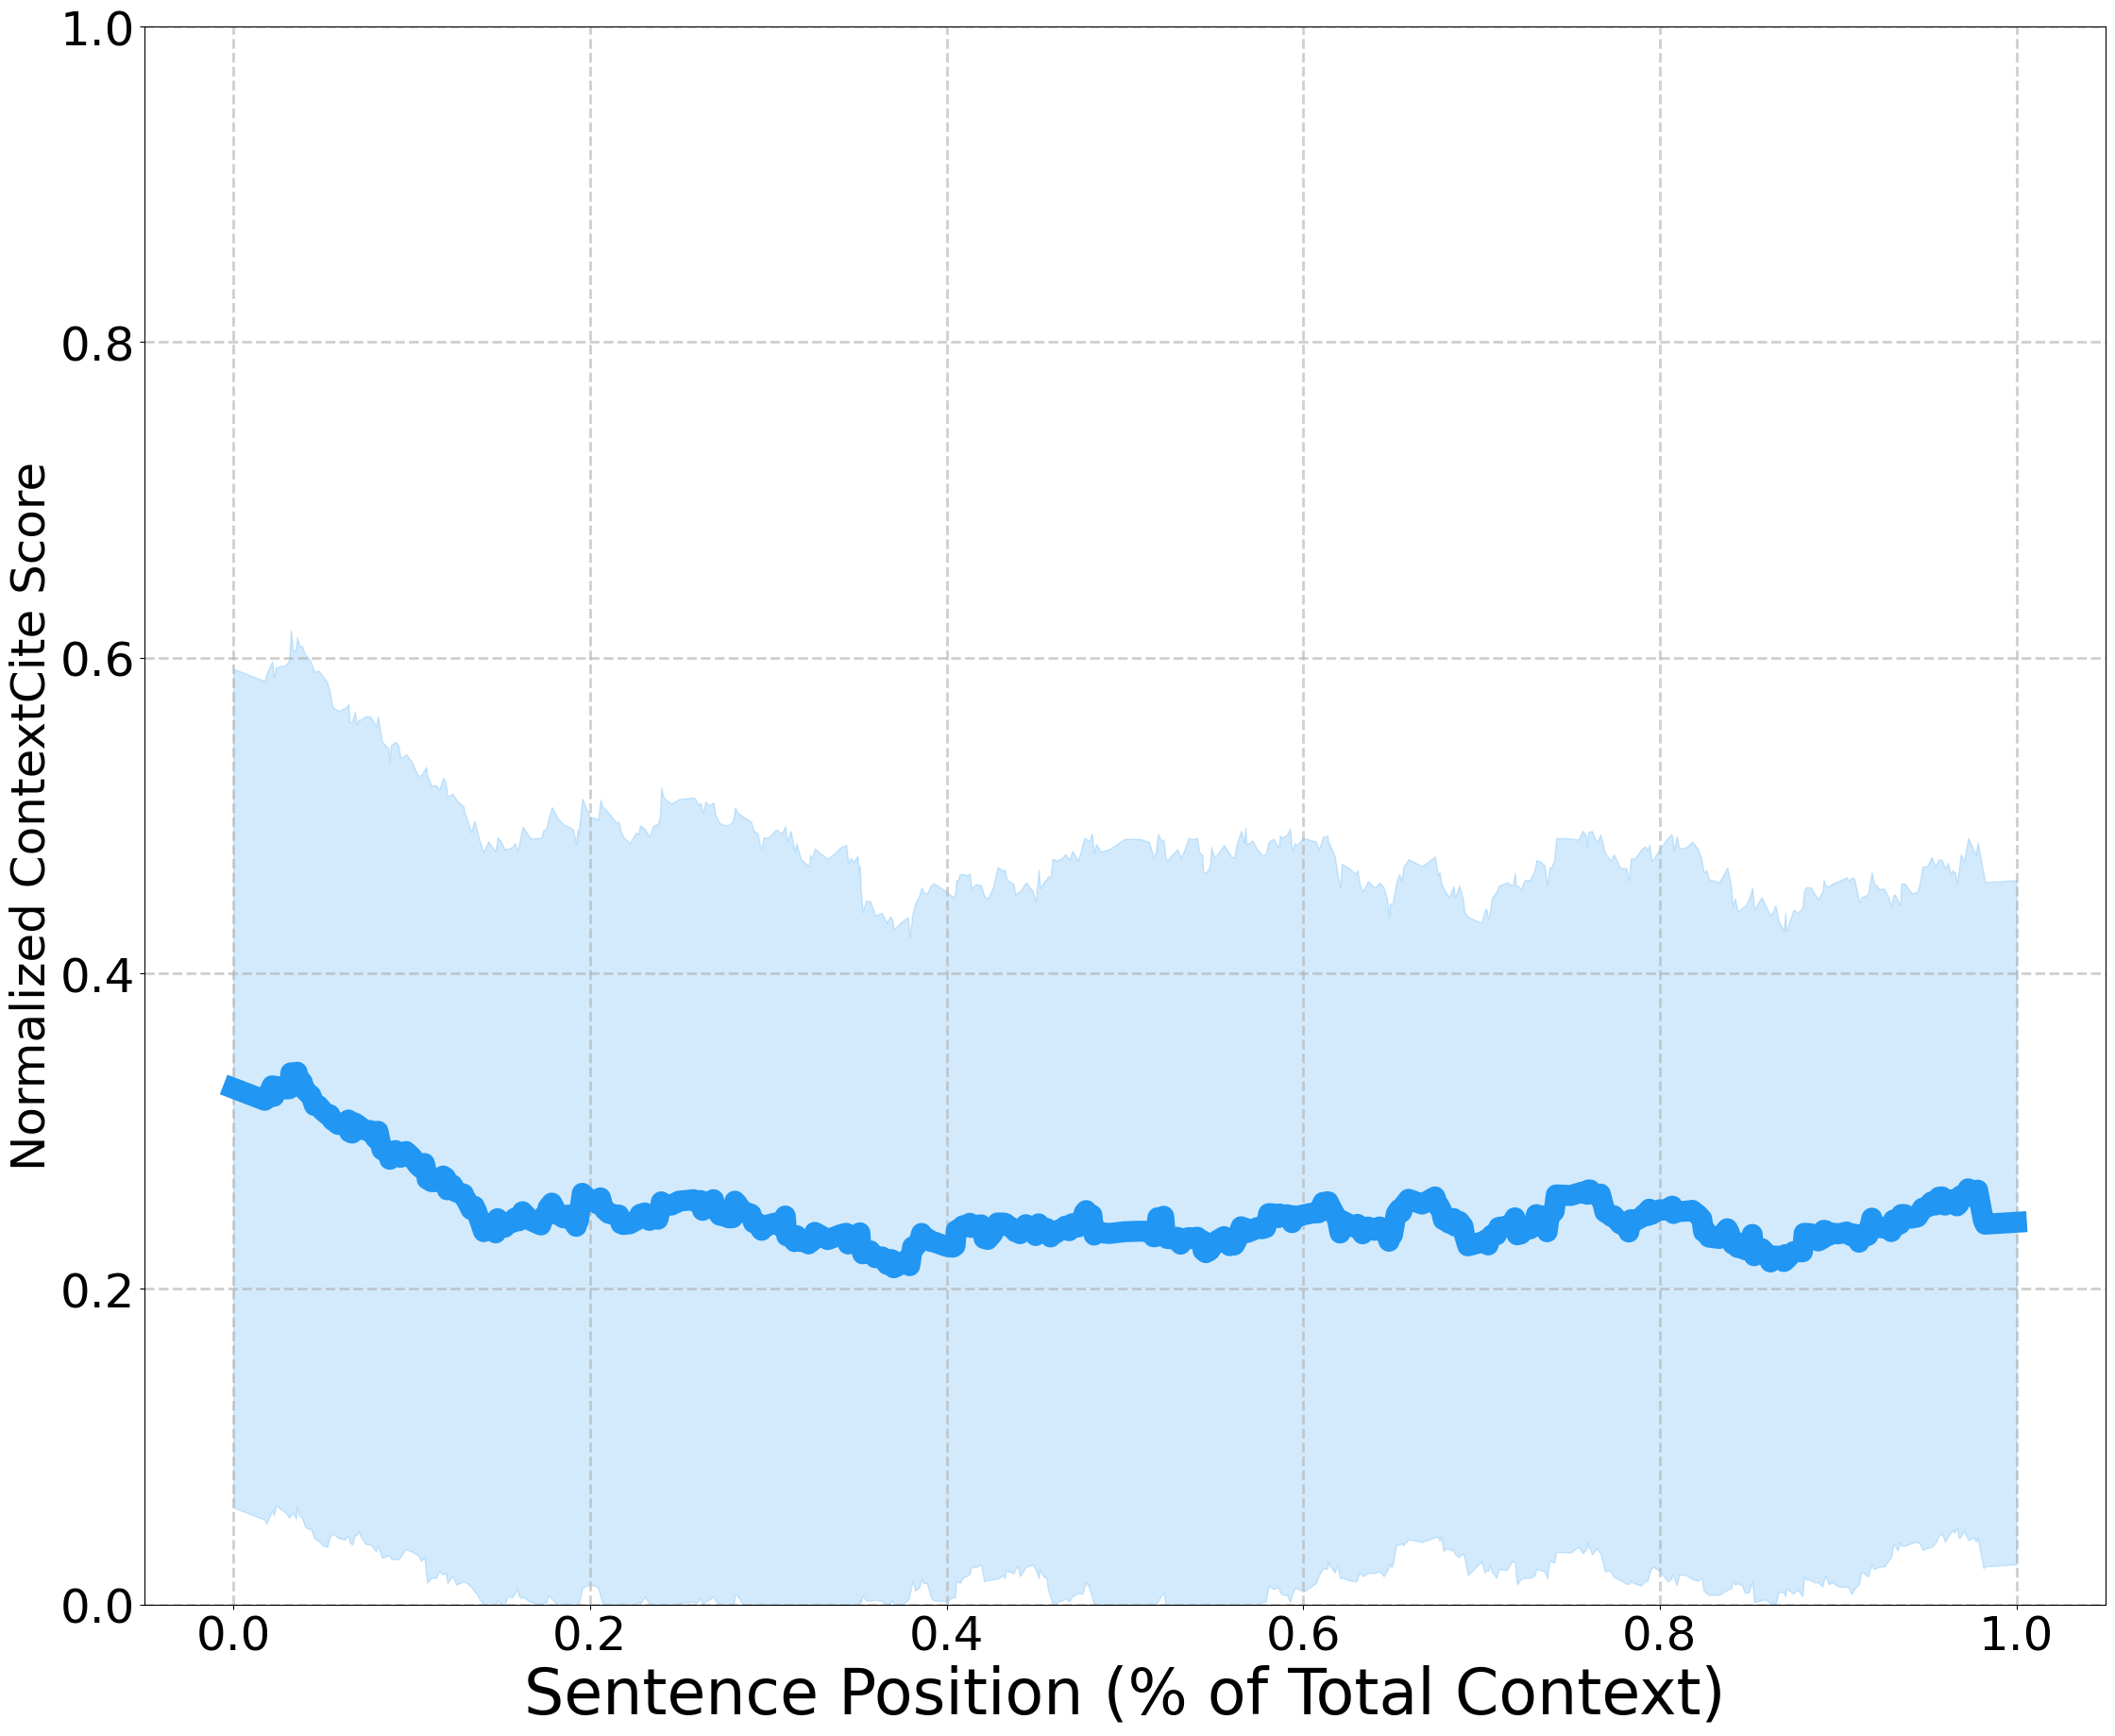

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ——— Scale up all fonts globally ———
mpl.rcParams['font.size']            = 60
mpl.rcParams['axes.titlesize']       = 50
mpl.rcParams['axes.labelsize']       = 40
mpl.rcParams['xtick.labelsize']      = 36
mpl.rcParams['ytick.labelsize']      = 36
mpl.rcParams['legend.fontsize']      = 36
mpl.rcParams['legend.title_fontsize']= 38
mpl.rcParams['figure.titlesize']     = 44

# ——— Data preparation ———
# Normalize Score within each QA_ID group
merged_df["Score"] = merged_df.groupby("QA_ID")["Score"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
)

# Compute relative sentence position
merged_df["position_idx"] = merged_df.groupby("QA_ID").cumcount()
merged_df["total_count"]  = merged_df.groupby("QA_ID")["Score"].transform("count")
merged_df = merged_df[merged_df["total_count"] > 1]
merged_df["position_pct"] = (
    merged_df["position_idx"] / (merged_df["total_count"] - 1)
)

# Drop trivial rows
merged_df = merged_df[merged_df["Source"].fillna("").str.strip() != "."]

# ——— Aggregate overall mean and std ———
# Group by the continuous position percentage
mean_score = merged_df.groupby("position_pct")["Score"].mean()
std_score  = merged_df.groupby("position_pct")["Score"].std()

# Apply rolling smoothing
window_size = 55
mean_smooth = mean_score.rolling(window=window_size, center=True, min_periods=1).mean()
std_smooth  = std_score.rolling(window=window_size, center=True, min_periods=1).mean()

# Filter out any NaNs after smoothing
valid = mean_smooth.notna() & std_smooth.notna()
x = mean_smooth[valid].index.values
y = mean_smooth[valid].values
err = std_smooth[valid].values

# ——— Plotting ———
fig, ax = plt.subplots(figsize=(24, 20))

ax.plot(x, y, color="#2196F3", linewidth=16, label="Overall")
y_lower = (y - err).clip(0, 1)
y_upper = (y + err).clip(0, 1)
ax.fill_between(x, y_lower, y_upper, color="#2196F3", alpha=0.2)

# ——— Axes formatting ———
ax.set_xlabel("Sentence Position (% of Total Context)", fontsize=48)
ax.set_ylabel("Normalized ContextCite Score", fontsize=36)
ax.grid(True, linestyle='--', linewidth=2, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=36)

# Force y‐axis to span 0–1
ax.set_ylim(0, 1)
# # ——— Legend (single entry) ———
# plt.subplots_adjust(right=0.75)  # make room on the right

# ax.legend(loc="upper right", title="Data Source", frameon=False)

# ——— Save & show ———
plt.tight_layout()
plt.savefig("Attribution_Score_Overall_Combined.pdf", format="pdf", dpi=300)
plt.show()


In [112]:
false_df

,QA_ID,Extracted_Answer,answer,Score,data_source,_pred,_true,Match?
19,Merge Q10,B,C,-0.224057,jama,B,C,FALSE
40,Merge Q1000,A,B,11.833522,jama,A,B,FALSE
52,Merge Q1001,D,B,7.863844,jama,D,B,FALSE
59,Merge Q1002,C,D,2.852696,jama,C,D,FALSE
63,Merge Q1003,A,B,5.067361,jama,A,B,FALSE
...,...,...,...,...,...,...,...,...
32041,Merge Q991,D,C,-0.385713,jama,D,C,FALSE
32083,Merge Q995,D,B,0.000000,jama,D,B,FALSE
32090,Merge Q996,A,C,0.588125,jama,A,C,FALSE
32113,Merge Q998,B,A,0.346237,jama,B,A,FALSE


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ——— Scale up all fonts globally ———
mpl.rcParams.update({
    'font.size':               60,
    'axes.titlesize':          50,
    'axes.labelsize':          40,
    'xtick.labelsize':         36,
    'ytick.labelsize':         36,
    'legend.fontsize':         36,
    'legend.title_fontsize':   38,
    'figure.titlesize':        44,
})

# ——— Data preparation ———
# (Re-load if necessary)
merged_df = pd.read_csv("MAJORITY_Vote_GPT4o_Self_Reported_Relevancy_Labels.csv")

# Rename ID→QA_ID if needed
if 'ID' in merged_df.columns and 'QA_ID' not in merged_df.columns:
    merged_df.rename(columns={'ID':'QA_ID'}, inplace=True)

# Normalize Score within each QA_ID group
merged_df["Score"] = merged_df.groupby("QA_ID")["Score"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
)

# Compute relative sentence position
merged_df["position_idx"] = merged_df.groupby("QA_ID").cumcount()
merged_df["total_count"]  = merged_df.groupby("QA_ID")["Score"].transform("count")
merged_df = merged_df[merged_df["total_count"] > 1]
merged_df["position_pct"] = merged_df["position_idx"] / (merged_df["total_count"] - 1)

# Drop trivial rows
merged_df = merged_df[merged_df["Source"].fillna("").str.strip() != "."]

# ——— Split by Match? flag ———
# Ensure Match? exists and is boolean
# (if it’s stored as string 'TRUE'/'FALSE', convert with .map({'TRUE':True,'FALSE':False}))
df_true  = merged_df[merged_df["Match?"] == True]
df_false = merged_df[merged_df["Match?"] == False]

# ——— Helper to compute smoothed mean by position_pct ———
window_size = 55
def get_smoothed(df):
    mean_score = df.groupby("position_pct")["Score"].mean()
    mean_smooth = mean_score.rolling(window_size, center=True, min_periods=1).mean()
    valid = mean_smooth.notna()
    return mean_smooth[valid].index.values, mean_smooth[valid].values

x_true,  y_true  = get_smoothed(df_true)
x_false, y_false = get_smoothed(df_false)

# ——— Plot both lines together ———
fig, ax = plt.subplots(figsize=(24, 20))

ax.plot(x_true,  y_true,  color="#ff7f0e", linewidth=16, label="Match? = True")
ax.plot(x_false, y_false, color="#2196F3", linewidth=16, label="Match? = False")

ax.set_xlabel("Sentence Position (% of Total Context)", fontsize=48)
ax.set_ylabel("Normalized ContextCite Score",        fontsize=36)
ax.grid(True, linestyle='--', linewidth=2, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=36)
ax.set_ylim(0, 1)

# Legend
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("Attribution_Score_By_Match.pdf", format="pdf", dpi=300)
plt.show()


KeyError: 'Column not found: Score'

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ——— Global font scaling ———
mpl.rcParams.update({
    'font.size':               60,
    'axes.titlesize':          50,
    'axes.labelsize':          40,
    'xtick.labelsize':         36,
    'ytick.labelsize':         36,
    'legend.fontsize':         36,
    'legend.title_fontsize':   38,
    'figure.titlesize':        44,
})

def plot_attribution_scores(df, label, score_col='Score'):
    """
    Normalize 'score_col' within each QA_ID, compute smoothed mean and std
    by sentence position, and save a stacked plot as PDF.
    """
    df = df.copy()
    # Normalize scores per QA_ID
    df[score_col] = (
        df.groupby("QA_ID")[score_col]
          .transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0)
    )
    # Compute relative position
    df["position_idx"] = df.groupby("QA_ID").cumcount()
    df["total_count"]  = df.groupby("QA_ID")[score_col].transform("count")
    df = df[df["total_count"] > 1]
    df["position_pct"] = df["position_idx"] / (df["total_count"] - 1)
    # Drop placeholder rows
    df = df[df["Source"].fillna("").str.strip() != "."]

    # Aggregate and smooth
    mean_score = df.groupby("position_pct")[score_col].mean().rolling(55, center=True, min_periods=1).mean()
    std_score  = df.groupby("position_pct")[score_col].std(ddof=0).rolling(55, center=True, min_periods=1).mean()

    valid = mean_score.notna() & std_score.notna()
    x = mean_score[valid].index.values
    y = mean_score[valid].values
    err = std_score[valid].values

    # Plot
    fig, ax = plt.subplots(figsize=(24, 20))
    ax.plot(x, y, color="#2196F3", linewidth=16, label=label)
    ax.fill_between(x, (y - err).clip(0, 1), (y + err).clip(0, 1), color="#2196F3", alpha=0.2)

    ax.set_title(f"Normalized {score_col} ({label})")
    ax.set_xlabel("Sentence Position (% of Total Context)")
    ax.set_ylabel("Normalized ContextCite Score")
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', linewidth=2, alpha=0.6)

    plt.tight_layout()
    path = f"/mnt/data/Attribution_Score_{label.replace(' ', '_')}.pdf"
    fig.savefig(path, format="pdf", dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved plot for '{label}' at: {path}")

# ——— Load and prepare DataFrames ———
merged_df = (
    pd.read_csv("MAJORITY_Vote_GPT4o_Self_Reported_Relevancy_Labels.csv")
      .rename(columns={'ID': 'QA_ID'})
)

df3 = (
    pd.read_csv("THIRD_annotated_2k_relevancy.csv")
      .rename(columns={'ID': 'QA_ID'})
)
df3['Match?'] = (
    df3['predicted_answer'].astype(str).str.strip().str.upper()
    == df3['answer'].astype(str).str.strip().str.upper()
)

# Merge match flag into merged_df
merged_df = merged_df.merge(df3[['QA_ID', 'Match?']], on='QA_ID', how='left')

# Split into correct and wrong subsets
correct_merged_df = merged_df[merged_df['Match?'] == True]
wrong_merged_df   = merged_df[merged_df['Match?'] == False]

# ——— Generate and save plots ———
plot_attribution_scores(correct_merged_df, "Correct Predictions")
plot_attribution_scores(wrong_merged_df,   "Wrong Predictions")


KeyError: 'Column not found: Score'

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ——— Scale up all fonts globally ———
mpl.rcParams['font.size']           = 60   # base
mpl.rcParams['axes.titlesize']      = 50
mpl.rcParams['axes.labelsize']      = 40
mpl.rcParams['xtick.labelsize']     = 36
mpl.rcParams['ytick.labelsize']     = 36
mpl.rcParams['legend.fontsize']     = 36
mpl.rcParams['legend.title_fontsize']= 38
mpl.rcParams['figure.titlesize']    = 44

# ——— Data preparation (unchanged) ———
# Normalize Score within each QA_ID group
merged_df["Score"] = merged_df.groupby("QA_ID")["Score"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
)

# Compute relative sentence position
merged_df["position_idx"] = merged_df.groupby("QA_ID").cumcount()
merged_df["total_count"]   = merged_df.groupby("QA_ID")["Score"].transform("count")
merged_df = merged_df[merged_df["total_count"] > 1]
merged_df["position_pct"]  = (
    merged_df["position_idx"] / (merged_df["total_count"] - 1)
)

# Drop trivial rows
merged_df = merged_df[merged_df["Source"].fillna("").str.strip() != "."]

# ——— Plotting ———
fig, ax = plt.subplots(figsize=(24, 20))
window_size = 55

colors = ["#2196F3", "#f5a525", "#9C27B0", "#4CAF50"]
sources = sorted(merged_df["data_source"].dropna().unique())

for i, source in enumerate(sources):
    subset = merged_df[merged_df["data_source"] == source]
    mean_score = subset.groupby("position_pct")["Score"].mean()
    std_score  = subset.groupby("position_pct")["Score"].std()
    mean_smooth= mean_score.rolling(window=window_size, center=True, min_periods=1).mean()
    std_smooth = std_score.rolling(window=window_size, center=True, min_periods=1).mean()

    valid = mean_smooth.notna() & std_smooth.notna()
    x   = mean_smooth[valid].index.values
    y   = mean_smooth[valid].values
    err = std_smooth[valid].values

    ax.plot(x, y,
            color=colors[i % len(colors)],
            linewidth=6,
            label=source)
    y_lo = (y - err).clip(0, 1)
    y_hi = (y + err).clip(0, 1)
    ax.fill_between(x, y_lo, y_hi,
                    color=colors[i % len(colors)],
                    alpha=0.2)

# ——— Axes formatting ———
ax.set_xlabel("Sentence Position (% of Total Context)", fontsize=48)
ax.set_ylabel("Normalized ContextCite Score", fontsize=36)
ax.grid(True, linestyle='--', linewidth=2, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=36)

# ——— Legend outside ———
# Allow room on the right for the legend
plt.subplots_adjust(right=0.75)
ax.legend(
    title="Data Source",
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=False
)

# ——— Save & show ———
plt.tight_layout()
plt.savefig("Attribution_Score_All_Sources_Combined.pdf", format="pdf", dpi=300)
plt.show()


KeyError: 'Column not found: Score'

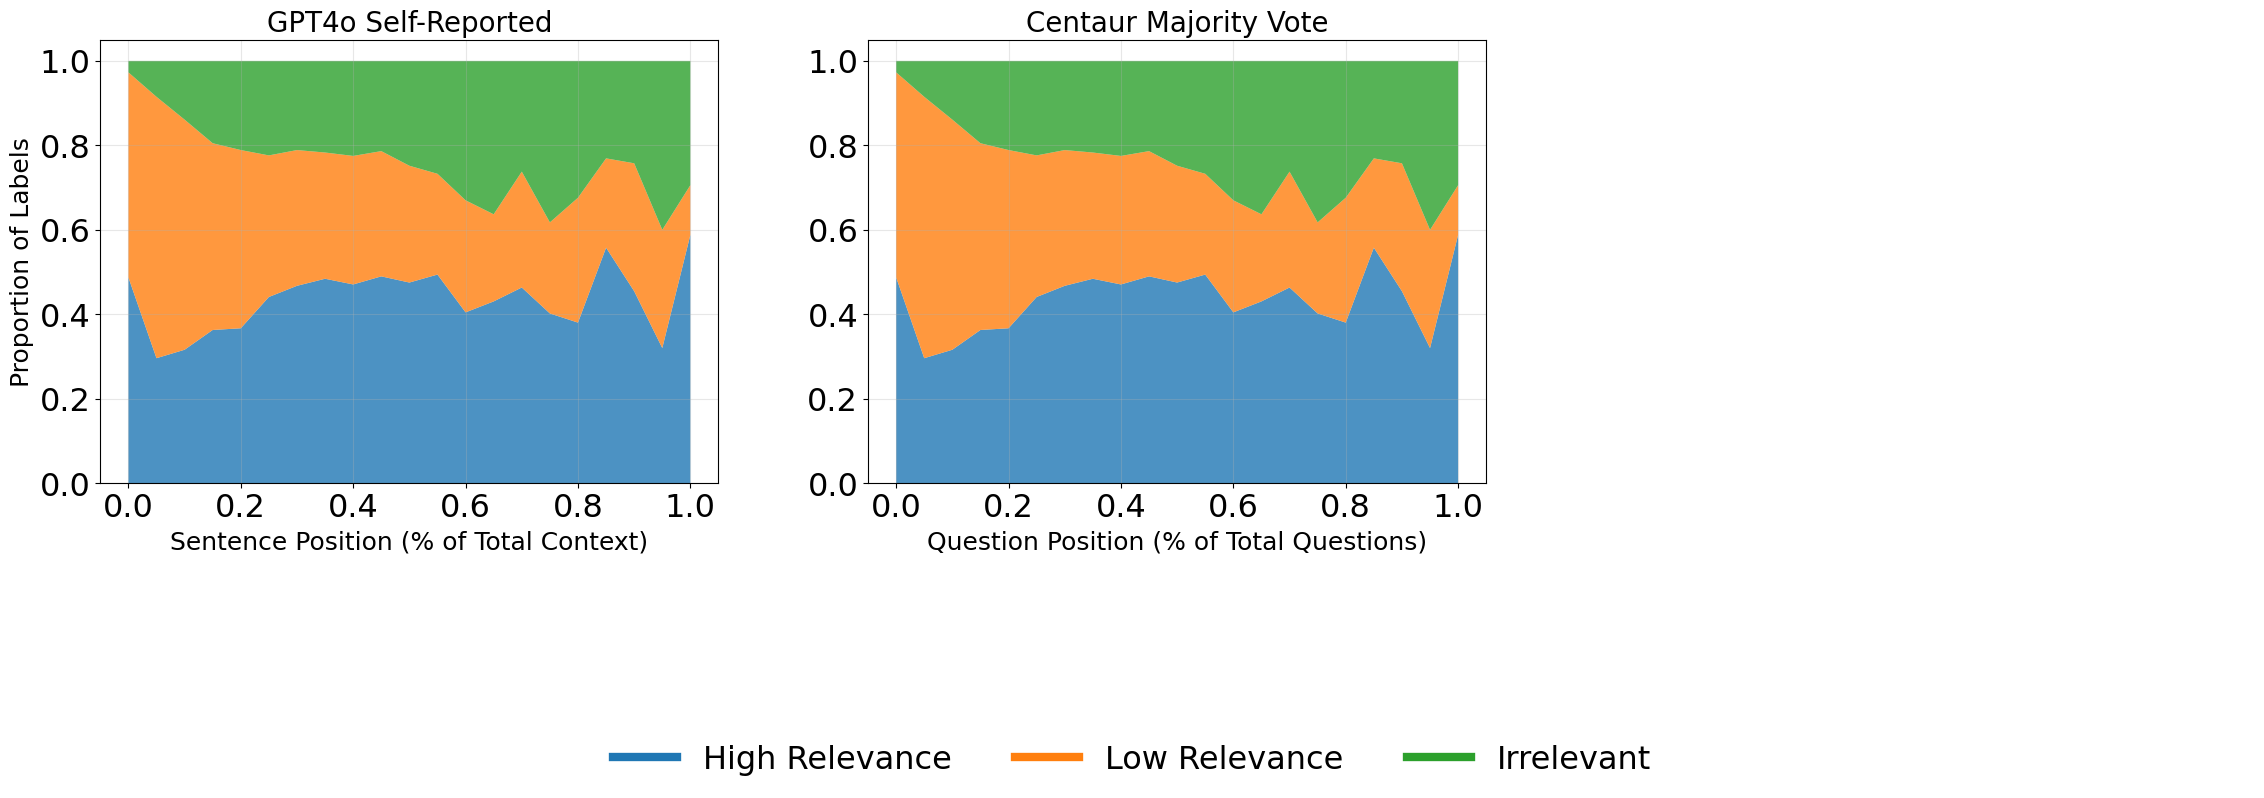

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# === Global Style ===
mpl.rcParams['font.size']            = 52
mpl.rcParams['axes.titlesize']       = 38
mpl.rcParams['axes.labelsize']       = 26
mpl.rcParams['xtick.labelsize']      = 23
mpl.rcParams['ytick.labelsize']      = 23
mpl.rcParams['legend.fontsize']      = 23
mpl.rcParams['legend.title_fontsize']= 25
mpl.rcParams['figure.titlesize']     = 30

# === Load Data for Panels 1 & 2 ===
maj_df = pd.read_csv("MAJORITY_Vote_GPT4o_Self_Reported_Relevancy_Labels.csv")

# === Compute proportions ===
label_cols = [f"label_{i}" for i in range(1, 22)]
labels     = ["High Relevance", "Low Relevance", "Irrelevant"]
label_map  = {lab: idx for idx, lab in enumerate(labels)}

counts = np.zeros((len(label_cols), len(labels)))
for idx, col in enumerate(label_cols):
    vc = maj_df[col].dropna().str.strip().value_counts()
    for lab, cnt in vc.items():
        if lab in label_map:
            counts[idx, label_map[lab]] = cnt

sums  = counts.sum(axis=1, keepdims=True)
props = np.divide(counts, sums, out=np.zeros_like(counts), where=sums!=0)
x = np.linspace(0, 1, len(label_cols))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# === Create 1×3 Subplots ===
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=False)

# Panel 1: GPT4o Self-Reported
axes[0].stackplot(x, props.T, labels=labels, colors=colors, alpha=0.8)
axes[0].set_title("GPT4o Self-Reported", fontsize=20)
axes[0].set_xlabel("Sentence Position (% of Total Context)", fontsize=18)
axes[0].set_ylabel("Proportion of Labels", fontsize=18)
axes[0].grid(alpha=0.3)

# Panel 2: Centaur Majority Vote
axes[1].stackplot(x, props.T, labels=labels, colors=colors, alpha=0.8)
axes[1].set_title("Centaur Majority Vote", fontsize=20)
axes[1].set_xlabel("Question Position (% of Total Questions)", fontsize=18)
axes[1].grid(alpha=0.3)

# Panel 3: blank
axes[2].axis('off')

# === Shared Legend ===
fig.legend(
    handles=[plt.Line2D([0],[0], color=colors[i], lw=6) for i in range(len(labels))],
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.savefig("combined_relevance_plots.pdf", format='pdf')
plt.show()
